# PINNs

## Dependencies

In [ ]:
import locale
locale.getpreferredencoding = lambda: "UTF-8"
!pip freeze > requirements.txt

## Data generation

In [1]:
import numpy as np
from scipy.interpolate import griddata
import matplotlib.pyplot as plt

In [2]:
class Sampler:
    # Initialize the class
    def __init__(self, dim, coords, func, name = None):
        self.dim = dim
        self.coords = coords
        self.func = func
        self.name = name
    def sample(self, N):
        x = self.coords[0:1,:] + (self.coords[1:2,:]-self.coords[0:1,:])*np.random.rand(N, self.dim)
        y = self.func(x)
        return x, y


In [3]:
# Define the exact solution and its derivatives
def u(x, a, c):
    """
    :param x: x = (t, x)
    """
    t = x[:,0:1]
    x = x[:,1:2]
    return np.sin(np.pi * x) * np.cos(c * np.pi * t) + \
            a * np.sin(2 * c * np.pi* x) * np.cos(4 * c  * np.pi * t)

def u_t(x,a, c):
    t = x[:,0:1]
    x = x[:,1:2]
    u_t = -  c * np.pi * np.sin(np.pi * x) * np.sin(c * np.pi * t) - \
            a * 4 * c * np.pi * np.sin(2 * c * np.pi* x) * np.sin(4 * c * np.pi * t)
    return u_t

def u_tt(x, a, c):
    t = x[:,0:1]
    x = x[:,1:2]
    u_tt = -(c * np.pi)**2 * np.sin( np.pi * x) * np.cos(c * np.pi * t) - \
            a * (4 * c * np.pi)**2 *  np.sin(2 * c * np.pi* x) * np.cos(4 * c * np.pi * t)
    return u_tt

def u_xx(x, a, c):
    t = x[:,0:1]
    x = x[:,1:2]
    u_xx = - np.pi**2 * np.sin( np.pi * x) * np.cos(c * np.pi * t) - \
              a * (2 * c * np.pi)** 2 * np.sin(2 * c * np.pi* x) * np.cos(4 * c * np.pi * t)
    return  u_xx


def r(x, a, c):
    return u_tt(x, a, c) - c**2 * u_xx(x, a, c)


In [4]:
# Domain boundaries
ics_coords = np.array([[0.0, 0.0],
                        [0.0, 1.0]])
bc1_coords = np.array([[0.0, 0.0],
                        [1.0, 0.0]])
bc2_coords = np.array([[0.0, 1.0],
                        [1.0, 1.0]])
dom_coords = np.array([[0.0, 0.0],
                        [1.0, 1.0]])

# Create initial conditions samplers
ics_sampler = Sampler(2, ics_coords, lambda x: u(x, a, c), name='Initial Condition 1')

# Create boundary conditions samplers
bc1 = Sampler(2, bc1_coords, lambda x: u(x, a, c), name='Dirichlet BC1')
bc2 = Sampler(2, bc2_coords, lambda x: u(x, a, c), name='Dirichlet BC2')
bcs_sampler = [bc1, bc2]

# Create residual sampler
res_sampler = Sampler(2, dom_coords, lambda x: r(x, a, c), name='Forcing')

In [5]:
a = 0.5
c = 2

## PINNs parameters

This PINNs is directly taken from https://github.com/PredictiveIntelligenceLab/PINNsNTK, implementing the algorithm from their paper *When and why PINNs fail to train: A neural tangent kernel perspective*, authored by Sifan Wang, Xinling Yu, and Paris Perdikaris.

In [6]:
import tensorflow.compat.v1 as tf
tf.disable_v2_behavior()
import timeit
import seaborn as sns
import pandas as pd
import os

Instructions for updating:
non-resource variables are not supported in the long term


In [7]:
class PINN:
    # Initialize the class
    def __init__(self, layers, operator, ics_sampler, bcs_sampler, res_sampler, c, kernel_size):
        # Normalization
        X, _ = res_sampler.sample(np.int32(1e5))
        self.mu_X, self.sigma_X = X.mean(0), X.std(0)
        self.mu_t, self.sigma_t = self.mu_X[0], self.sigma_X[0]
        self.mu_x, self.sigma_x = self.mu_X[1], self.sigma_X[1]

        # Samplers
        self.operator = operator
        self.ics_sampler = ics_sampler
        self.bcs_sampler = bcs_sampler
        self.res_sampler = res_sampler

        # Initialize network weights and biases
        self.layers = layers
        self.weights, self.biases = self.initialize_NN(layers)

        # weights
        self.lam_u_val = np.array(1.0)
        self.lam_ut_val = np.array(1.0)
        self.lam_r_val = np.array(1.0)

        # Wave constant
        self.c = tf.constant(c, dtype=tf.float32)

        self.kernel_size = kernel_size # Size of the NTK matrix

        # Define Tensorflow session
        self.sess = tf.Session(config=tf.ConfigProto(log_device_placement=True))

        # Define placeholders and computational graph
        self.t_u_tf = tf.placeholder(tf.float32, shape=(None, 1))
        self.x_u_tf = tf.placeholder(tf.float32, shape=(None, 1))

        self.t_ics_tf = tf.placeholder(tf.float32, shape=(None, 1))
        self.x_ics_tf = tf.placeholder(tf.float32, shape=(None, 1))
        self.u_ics_tf = tf.placeholder(tf.float32, shape=(None, 1))

        self.t_bc1_tf = tf.placeholder(tf.float32, shape=(None, 1))
        self.x_bc1_tf = tf.placeholder(tf.float32, shape=(None, 1))

        self.t_bc2_tf = tf.placeholder(tf.float32, shape=(None, 1))
        self.x_bc2_tf = tf.placeholder(tf.float32, shape=(None, 1))

        self.t_r_tf = tf.placeholder(tf.float32, shape=(None, 1))
        self.x_r_tf = tf.placeholder(tf.float32, shape=(None, 1))

        self.lam_u_tf = tf.placeholder(tf.float32, shape=self.lam_u_val.shape)
        self.lam_ut_tf = tf.placeholder(tf.float32, shape=self.lam_u_val.shape)
        self.lam_r_tf = tf.placeholder(tf.float32, shape=self.lam_u_val.shape)


        # Evaluate predictions
        self.u_ics_pred = self.net_u(self.t_ics_tf, self.x_ics_tf)
        self.u_t_ics_pred = self.net_u_t(self.t_ics_tf, self.x_ics_tf)
        self.u_bc1_pred = self.net_u(self.t_bc1_tf, self.x_bc1_tf)
        self.u_bc2_pred = self.net_u(self.t_bc2_tf, self.x_bc2_tf)

        self.u_pred = self.net_u(self.t_u_tf, self.x_u_tf)
        self.r_pred = self.net_r(self.t_r_tf, self.x_r_tf)


        # Boundary loss and Initial loss
        self.loss_ics_u = tf.reduce_mean(tf.square(self.u_ics_tf - self.u_ics_pred))
        self.loss_ics_u_t = tf.reduce_mean(tf.square(self.u_t_ics_pred))
        self.loss_bc1 = tf.reduce_mean(tf.square(self.u_bc1_pred))
        self.loss_bc2 = tf.reduce_mean(tf.square(self.u_bc2_pred))

        self.loss_bcs = self.loss_ics_u + self.loss_bc1 + self.loss_bc2

        # Residual loss
        self.loss_res = tf.reduce_mean(tf.square(self.r_pred))

        # Total loss
        self.loss = self.lam_r_tf * self.loss_res + self.lam_u_tf * self.loss_bcs + self.lam_ut_tf * self.loss_ics_u_t

        # Define optimizer with learning rate schedule
        self.global_step = tf.Variable(0, trainable=False)
        starter_learning_rate = 1e-3
        self.learning_rate = tf.train.exponential_decay(starter_learning_rate, self.global_step,
                                                        1000, 0.9, staircase=False)
        # Passing global_step to minimize() will increment it at each step.
        self.train_op = tf.train.AdamOptimizer(self.learning_rate).minimize(self.loss, global_step=self.global_step)

        # Logger
        self.loss_bcs_log = []
        self.loss_ut_ics_log = []
        self.loss_res_log = []
        self.saver = tf.train.Saver()


        # weights logger
        self.lam_u_log = []
        self.lam_ut_log = []
        self.lam_r_log = []

         # Initialize Tensorflow variables
        init = tf.global_variables_initializer()
        self.sess.run(init)

    # Initialize network weights and biases using Xavier initialization
    def initialize_NN(self, layers):
        # Xavier initialization
        def xavier_init(size):
            in_dim = size[0]
            out_dim = size[1]
            xavier_stddev = 1. / np.sqrt((in_dim + out_dim) / 2.)
            return tf.Variable(tf.random.normal([in_dim, out_dim], dtype=tf.float32) * xavier_stddev,
                               dtype=tf.float32)

        weights = []
        biases = []
        num_layers = len(layers)
        for l in range(0, num_layers - 1):
            W = xavier_init(size=[layers[l], layers[l + 1]])
            b = tf.Variable(tf.zeros([1, layers[l + 1]], dtype=tf.float32), dtype=tf.float32)
            weights.append(W)
            biases.append(b)
        return weights, biases

    # Evaluates the forward pass
    def forward_pass(self, H, layers, weights, biases):
        num_layers = len(layers)
        for l in range(0, num_layers - 2):
            W = weights[l]
            b = biases[l]
            H = tf.tanh(tf.add(tf.matmul(H, W), b))
        W = weights[-1]
        b = biases[-1]
        H = tf.add(tf.matmul(H, W), b)
        return H

    # Forward pass for u
    def net_u(self, t, x):
        u = self.forward_pass(tf.concat([t, x], 1),
                              self.layers,
                              self.weights,
                              self.biases)
        return u

    # Forward pass for du/dt
    def net_u_t(self, t, x):
        u_t = tf.gradients(self.net_u(t, x), t)[0] / self.sigma_t
        return u_t

    # Forward pass for the residual
    def net_r(self, t, x):
        u = self.net_u(t, x)
        residual = self.operator(u, t, x,
                                 self.c,
                                 self.sigma_t,
                                 self.sigma_x)
        return residual



    def fetch_minibatch(self, sampler, N):
        X, Y = sampler.sample(N)
        X = (X - self.mu_X) / self.sigma_X
        return X, Y

        # Trains the model by minimizing the MSE loss

    def train(self, nIter=10000, batch_size=128):

        start_time = timeit.default_timer()
        for it in range(nIter):
            # Fetch boundary mini-batches
            X_ics_batch, u_ics_batch = self.fetch_minibatch(self.ics_sampler, batch_size // 3)
            X_bc1_batch, _ = self.fetch_minibatch(self.bcs_sampler[0], batch_size // 3)
            X_bc2_batch, _ = self.fetch_minibatch(self.bcs_sampler[1], batch_size // 3)

            # Fetch residual mini-batch
            X_res_batch, _ = self.fetch_minibatch(self.res_sampler, batch_size)

            # Define a dictionary for associating placeholders with data
            tf_dict = {self.t_ics_tf: X_ics_batch[:, 0:1], self.x_ics_tf: X_ics_batch[:, 1:2],
                       self.u_ics_tf: u_ics_batch,
                       self.t_bc1_tf: X_bc1_batch[:, 0:1], self.x_bc1_tf: X_bc1_batch[:, 1:2],
                       self.t_bc2_tf: X_bc2_batch[:, 0:1], self.x_bc2_tf: X_bc2_batch[:, 1:2],
                       self.t_r_tf: X_res_batch[:, 0:1], self.x_r_tf: X_res_batch[:, 1:2],
                       self.lam_u_tf: self.lam_u_val,
                       self.lam_ut_tf: self.lam_ut_val,
                       self.lam_r_tf: self.lam_r_val}

            # Run the Tensorflow session to minimize the loss
            self.sess.run(self.train_op, tf_dict)

            # Print
            if it % 100 == 0:
                elapsed = timeit.default_timer() - start_time

                loss_value = self.sess.run(self.loss, tf_dict)
                loss_bcs_value = self.sess.run(self.loss_bcs, tf_dict)
                loss_ics_ut_value = self.sess.run(self.loss_ics_u_t, tf_dict)
                loss_res_value = self.sess.run(self.loss_res, tf_dict)

                # Store losses
                self.loss_bcs_log.append(loss_bcs_value)
                self.loss_res_log.append(loss_res_value)
                self.loss_ut_ics_log.append(loss_ics_ut_value)

                print('It: %d, Loss: %.3e, Loss_res: %.3e,  Loss_bcs: %.3e, Loss_ut_ics: %.3e,, Time: %.2f' %
                      (it, loss_value, loss_res_value, loss_bcs_value, loss_ics_ut_value, elapsed))

                print('lambda_u: {:.3e}'.format(self.lam_u_val))
                print('lambda_ut: {:.3e}'.format(self.lam_ut_val))
                print('lambda_r: {:.3e}'.format(self.lam_r_val))

                start_time = timeit.default_timer()



    # Evaluates predictions at test points
    def predict_u(self, X_star):
        X_star = (X_star - self.mu_X) / self.sigma_X
        tf_dict = {self.t_u_tf: X_star[:, 0:1], self.x_u_tf: X_star[:, 1:2]}
        u_star = self.sess.run(self.u_pred, tf_dict)
        return u_star

        # Evaluates predictions at test points

    def predict_r(self, X_star):
        X_star = (X_star - self.mu_X) / self.sigma_X
        tf_dict = {self.t_r_tf: X_star[:, 0:1], self.x_r_tf: X_star[:, 1:2]}
        r_star = self.sess.run(self.r_pred, tf_dict)
        return r_star

In [8]:
def operator(u, t, x, c, sigma_t=1.0, sigma_x=1.0):
    u_t = tf.gradients(u, t)[0] / sigma_t
    u_x = tf.gradients(u, x)[0] / sigma_x
    u_tt = tf.gradients(u_t, t)[0] / sigma_t
    u_xx = tf.gradients(u_x, x)[0] / sigma_x
    residual = u_tt - c**2 * u_xx
    return residual

## PINNs training

In [30]:
# Define PINN model
layers = [2, 500, 500, 500, 1]
kernel_size = 300
model = PINN(layers, operator, ics_sampler, bcs_sampler, res_sampler, c, kernel_size)

# Train model
iterations = 80001
model.train(nIter=iterations, batch_size=kernel_size)

Device mapping:
/job:localhost/replica:0/task:0/device:GPU:0 -> device: 0, name: NVIDIA L4, pci bus id: 0000:00:03.0, compute capability: 8.9

It: 0, Loss: 2.085e+01, Loss_res: 6.656e+00,  Loss_bcs: 8.866e+00, Loss_ut_ics: 5.327e+00,, Time: 1.14
lambda_u: 1.000e+00
lambda_ut: 1.000e+00
lambda_r: 1.000e+00
It: 100, Loss: 4.005e-01, Loss_res: 3.616e-03,  Loss_bcs: 3.750e-01, Loss_ut_ics: 2.184e-02,, Time: 0.55
lambda_u: 1.000e+00
lambda_ut: 1.000e+00
lambda_r: 1.000e+00
It: 200, Loss: 3.963e-01, Loss_res: 6.909e-03,  Loss_bcs: 3.877e-01, Loss_ut_ics: 1.726e-03,, Time: 0.55
lambda_u: 1.000e+00
lambda_ut: 1.000e+00
lambda_r: 1.000e+00
It: 300, Loss: 3.303e-01, Loss_res: 2.208e-02,  Loss_bcs: 2.916e-01, Loss_ut_ics: 1.659e-02,, Time: 0.55
lambda_u: 1.000e+00
lambda_ut: 1.000e+00
lambda_r: 1.000e+00
It: 400, Loss: 2.682e-01, Loss_res: 6.847e-03,  Loss_bcs: 2.409e-01, Loss_ut_ics: 2.053e-02,, Time: 0.54
lambda_u: 1.000e+00
lambda_ut: 1.000e+00
lambda_r: 1.000e+00
It: 500, Loss: 2.344e-01, Los

**Training Loss**

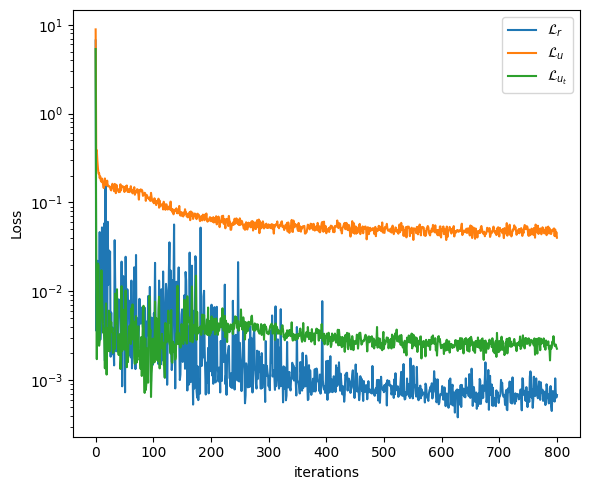

In [31]:
loss_res = model.loss_res_log
loss_bcs = model.loss_bcs_log
loss_u_t_ics = model.loss_ut_ics_log

fig = plt.figure(figsize=(6, 5))
plt.plot(loss_res, label='$\mathcal{L}_{r}$')
plt.plot(loss_bcs, label='$\mathcal{L}_{u}$')
plt.plot(loss_u_t_ics, label='$\mathcal{L}_{u_t}$')
plt.yscale('log')
plt.xlabel('iterations')
plt.ylabel('Loss')
plt.legend()
plt.tight_layout()
plt.show()

**Model Prediction**

In [32]:
nn = 100
t = np.linspace(dom_coords[0, 0], dom_coords[1, 0], nn)[:, None]
x = np.linspace(dom_coords[0, 1], dom_coords[1, 1], nn)[:, None]
t, x = np.meshgrid(t, x)
X_star = np.hstack((t.flatten()[:, None], x.flatten()[:, None]))

u_star = u(X_star, a,c)
R_star = r(X_star, a, c)

# Predictions
u_pred = model.predict_u(X_star)
r_pred = model.predict_r(X_star)
error_u = np.linalg.norm(u_star - u_pred, 2) / np.linalg.norm(u_star, 2)

print('Relative L2 error_u: %e' % (error_u))

Relative L2 error_u: 4.300666e-01


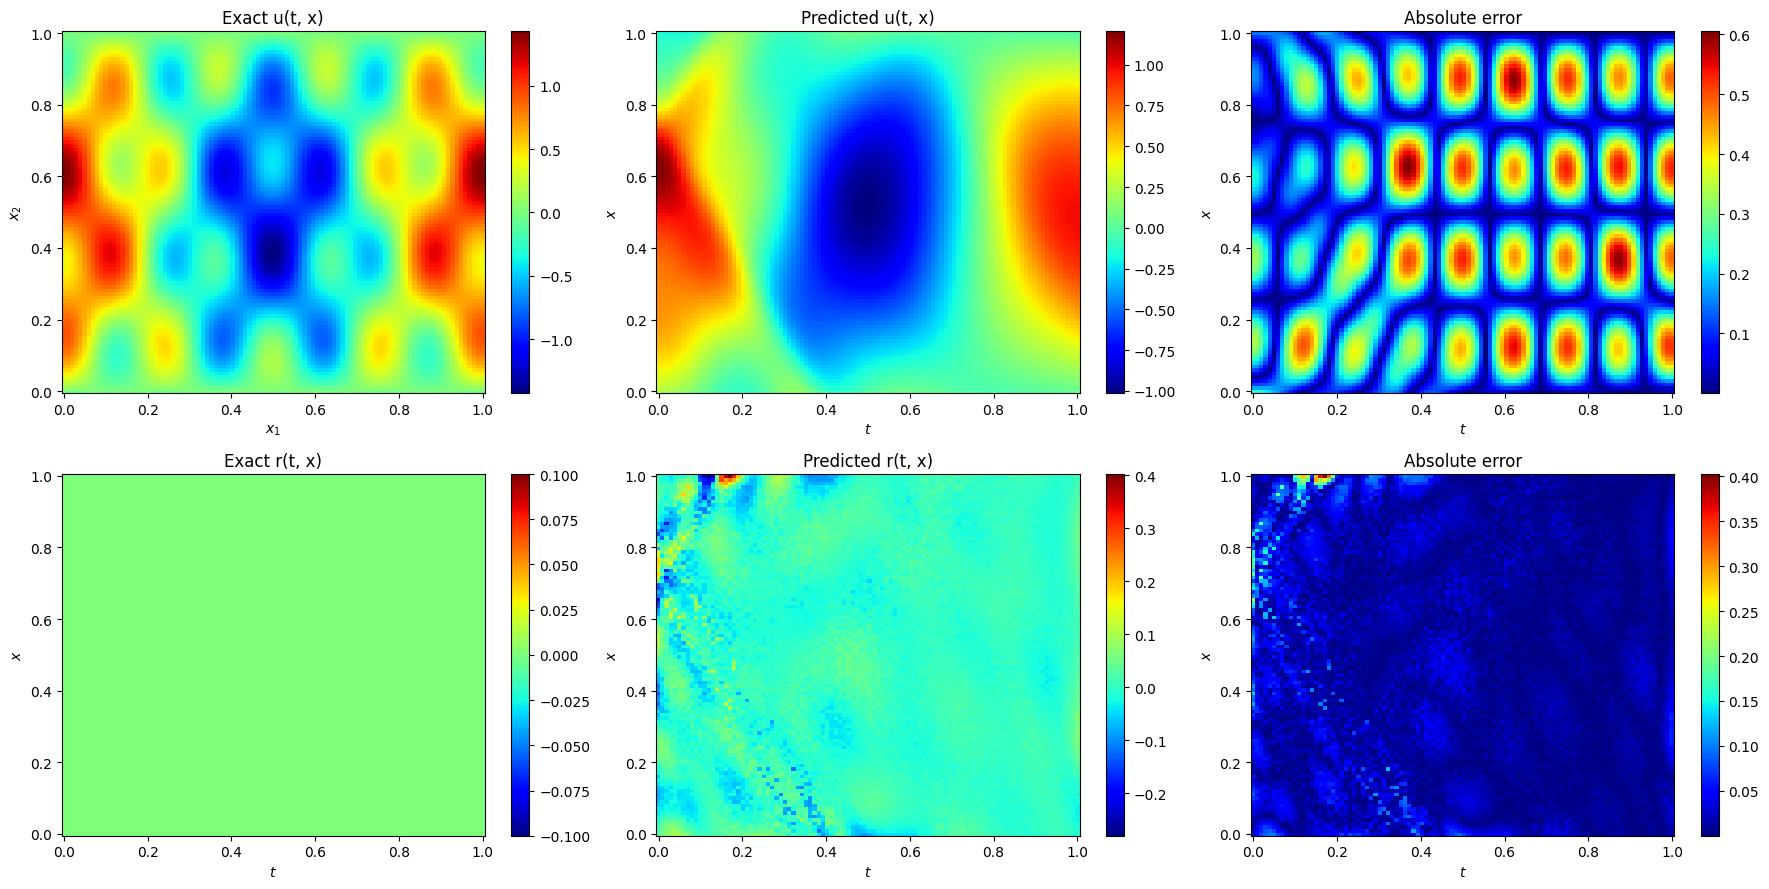

In [33]:
U_star = griddata(X_star, u_star.flatten(), (t, x), method='cubic')
R_star = griddata(X_star, R_star.flatten(), (t, x), method='cubic')
U_pred = griddata(X_star, u_pred.flatten(), (t, x), method='cubic')
R_pred = griddata(X_star, r_pred.flatten(), (t, x), method='cubic')


plt.figure(figsize=(18, 9))
plt.subplot(2, 3, 1)
plt.pcolor(t, x, U_star, cmap='jet')
plt.colorbar()
plt.xlabel('$x_1$')
plt.ylabel('$x_2$')
plt.title('Exact u(t, x)')
plt.tight_layout()

plt.subplot(2, 3, 2)
plt.pcolor(t, x, U_pred, cmap='jet')
plt.colorbar()
plt.xlabel('$t$')
plt.ylabel('$x$')
plt.title('Predicted u(t, x)')
plt.tight_layout()

plt.subplot(2, 3, 3)
plt.pcolor(t, x, np.abs(U_star - U_pred), cmap='jet')
plt.colorbar()
plt.xlabel('$t$')
plt.ylabel('$x$')
plt.title('Absolute error')
plt.tight_layout()

plt.subplot(2, 3, 4)
plt.pcolor(t, x, R_star, cmap='jet')
plt.colorbar()
plt.xlabel('$t$')
plt.ylabel('$x$')
plt.title('Exact r(t, x)')
plt.tight_layout()

plt.subplot(2, 3, 5)
plt.pcolor(t, x, R_pred, cmap='jet')
plt.colorbar()
plt.xlabel('$t$')
plt.ylabel('$x$')
plt.title('Predicted r(t, x)')
plt.tight_layout()

plt.subplot(2, 3, 6)
plt.pcolor(t, x, np.abs(R_star - R_pred), cmap='jet')
plt.colorbar()
plt.xlabel('$t$')
plt.ylabel('$x$')
plt.title('Absolute error')
plt.tight_layout()

plt.savefig('pinns.pdf', bbox_inches='tight')
plt.show()


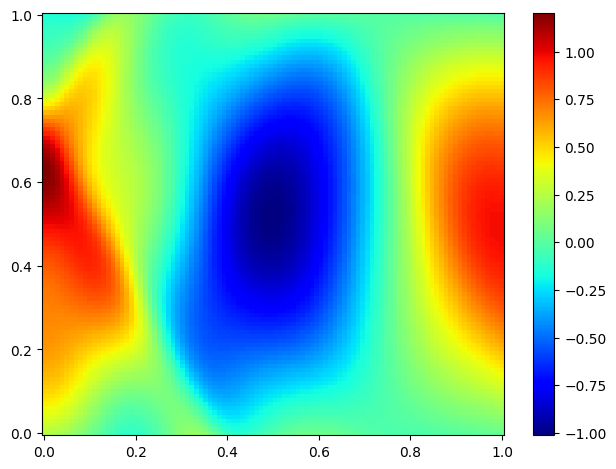

In [36]:
plt.pcolor(t, x, U_pred, cmap='jet')
plt.colorbar()
plt.tight_layout()

plt.savefig('pinns.pdf', bbox_inches='tight')

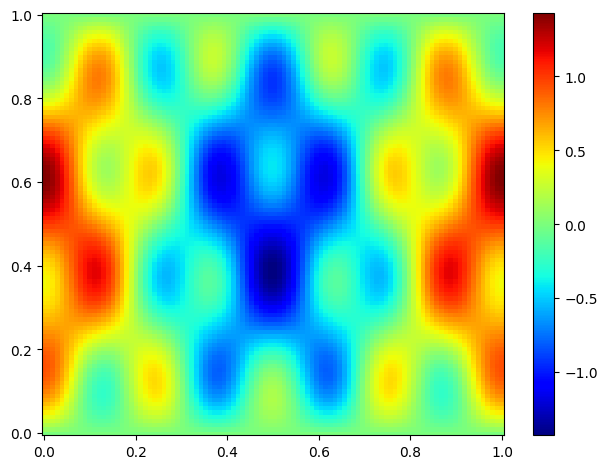

In [38]:
plt.pcolor(t, x, U_star, cmap='jet')
plt.colorbar()
plt.tight_layout()


plt.savefig('ground_truth.pdf', bbox_inches='tight')

# PIKL

## PIK package

In [ ]:
# Allows to automatically switch from CPU to GPU
import torch
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

torch.set_default_dtype(torch.float64)

def is_running_on_gpu():
  if torch.cuda.is_available():
    print("The algorithm is running on GPU.")
  else:
    print("The algorithm is not running on GPU.")

In [ ]:
import pandas as pd

In [ ]:
def Sob_formula(k1, k2, j1, j2, s, L):
    return torch.where(torch.logical_and(k1 == j1, k2 == j2), 1+ (k1**2 + k2**2)**s/(2*L)**(2*s), 0.)


def Sob_matrix(m, s, L, device):
  fourier_range = torch.arange(-m, m+1, device=device)
  k1, k2, j1, j2 = torch.meshgrid(fourier_range, fourier_range, fourier_range, fourier_range, indexing='ij')
  k1 = k1.flatten()
  k2 = k2.flatten()
  j1 = j1.flatten()
  j2 = j2.flatten()

  sob_values = Sob_formula(k1, k2, j1, j2, s, L)

  return sob_values.view((2*m+1)**2, (2*m+1)**2)

In [ ]:
class DifferentialOperator:
    def __init__(self, coefficients=None):
        """
        Initialize the PDE.
        The keys are tuples representing the powers of d/dX and d/dY respectively.
        For example, {(2, 1): 3, (0, 0): -1} represents 3d^2/dX^2 d/dY - 1.
        """
        if coefficients is None:
            self.coefficients = {}
        else:
            self.coefficients = coefficients

    def __repr__(self):
        terms = []
        for (x_power, y_power), coefficient in sorted(self.coefficients.items(), reverse=True):
            if coefficient == 0:
                continue
            term = f"{coefficient}"
            if x_power != 0:
                term += f"*(d/dX)^{x_power}"
            if y_power != 0:
                term += f"*(d/dY)^{y_power}"
            terms.append(term)
        PDE = " + ".join(terms) if terms else "0"
        return "The PDE of your model is " + PDE + " = 0."

    def __add__(self, other):
        if isinstance(other, (int, float)):
            result = DifferentialOperator(self.coefficients.copy())
            if (0, 0) in result.coefficients:
                result.coefficients[(0, 0)] += other
            else:
                result.coefficients[(0, 0)] = other
            return result

        result = DifferentialOperator(self.coefficients.copy())
        for (x_power, y_power), coefficient in other.coefficients.items():
            if (x_power, y_power) in result.coefficients:
                result.coefficients[(x_power, y_power)] += coefficient
            else:
                result.coefficients[(x_power, y_power)] = coefficient
        return result

    def __radd__(self, other):
        return self.__add__(other)

    def __sub__(self, other):
        result = DifferentialOperator(self.coefficients.copy())
        for (x_power, y_power), coefficient in other.coefficients.items():
            if (x_power, y_power) in result.coefficients:
                result.coefficients[(x_power, y_power)] -= coefficient
            else:
                result.coefficients[(x_power, y_power)] = -coefficient
        return result

    def __mul__(self, other):
        if isinstance(other, (int, float)):
            result = DifferentialOperator()
            for (x_power, y_power), coefficient in self.coefficients.items():
                result.coefficients[(x_power, y_power)] = coefficient * other
            return result

        result = DifferentialOperator()
        for (x1, y1), c1 in self.coefficients.items():
            for (x2, y2), c2 in other.coefficients.items():
                power = (x1 + x2, y1 + y2)
                if power in result.coefficients:
                    result.coefficients[power] += c1 * c2
                else:
                    result.coefficients[power] = c1 * c2
        return result

    def __rmul__(self, other):
        return self.__mul__(other)

    def __pow__(self, exponent):
        if exponent == 0:
            return DifferentialOperator({(0, 0): 1})
        elif exponent < 0:
            raise ValueError("Exponent must be a non-negative integer")

        result = DifferentialOperator(self.coefficients.copy())
        for _ in range(1, exponent):
            result *= self
        return result

    def evaluate(self, x, y, L):
        total = 0
        geometry = 1j*torch.pi/2/L
        for (x_power, y_power), coefficient in self.coefficients.items():
            total += coefficient * (x ** x_power) * (y ** y_power) * (geometry **(x_power + y_power))
        return total


In [ ]:
def Fourier_PDE(k1, k2, j1, j2, L, PDE):
  return torch.where(torch.logical_and(k1 == j1, k2 == j2), PDE.evaluate(k1,k2, L), 0.)

def PDE_matrix(m, L, PDE, device):
  fourier_range = torch.arange(-m, m+1, device=device)
  k1, k2, j1, j2 = torch.meshgrid(fourier_range, fourier_range, fourier_range, fourier_range, indexing='ij')
  k1 = k1.flatten()
  k2 = k2.flatten()
  j1 = j1.flatten()
  j2 = j2.flatten()

  PDE_values = Fourier_PDE(k1, k2, j1, j2, L, PDE)

  return PDE_values.view((2*m+1)**2, (2*m+1)**2)

In [ ]:
def Omega_matrix(domain, m, device):
  if domain == "square":
    fourier_range = torch.arange(-m, m+1, device=device)
    k1, k2, j1, j2 = torch.meshgrid(fourier_range, fourier_range, fourier_range, fourier_range, indexing='ij')
    k1 = (k1-j1).flatten()
    k2 = (k2-j2).flatten()
    j1, j2 = None, None

    T_values =  torch.mul(torch.sinc(k1/2), torch.sinc(k2/2))/4

    return T_values.view((2*m+1)**2, (2*m+1)**2)
  elif domain == "disk":
    fourier_range = torch.arange(-m, m+1, device=device)
    k1, k2, j1, j2 = torch.meshgrid(fourier_range, fourier_range, fourier_range, fourier_range, indexing='ij')
    k1 = (k1-j1).flatten()
    k2 = (k2-j2).flatten()
    j1, j2 = None, None

    T_values = torch.where(torch.logical_or(k1!= 0, k2 != 0),
                           torch.special.bessel_j1(torch.pi/2*torch.sqrt(k1**2+k2**2))/4/torch.sqrt(k1**2+k2**2), torch.pi/16)
    return T_values.view((2*m+1)**2, (2*m+1)**2)

In [ ]:
def phi_matrix(mat_x, mat_y, mat_j1, mat_j2, L):
  return torch.exp(torch.pi/L*(torch.mul(mat_x, mat_j1)+torch.mul(mat_y, mat_j2))*1j/2)

def M_mat(s, m, lambda_n, mu_n, L, domain, PDE, device):
  S = Sob_matrix(m, s, L, device)*(1.0+0*1j)
  P = PDE_matrix(m, L, PDE, device)*(1.0+0*1j)
  T = Omega_matrix(domain, m, device)*(1.0+0*1j)
  M = lambda_n * S + mu_n * torch.transpose(torch.conj_physical(P), 0, 1)@T@P
  return M

def RFF_fit(data_t, data_x, data_y, s, m, lambda_n, mu_n, L, domain, PDE, device):
  M = M_mat(s, m, lambda_n, mu_n, L, domain, PDE, device)
  return RFF(m, data_t, data_x, data_y, L,  M, device)

def RFF(m, data_t, data_x, data_y, L, M, device):
  l = len(data_x)

  mat_t = torch.tile(data_t, ((2*m+1)**2,1))
  mat_x = torch.tile(data_x, ((2*m+1)**2,1))

  fourier_range = torch.arange(-m, m+1, device=device)
  fourier_rangex = torch.arange(l, device=device)

  j1, j2,  k1 = torch.meshgrid( fourier_range, fourier_range, fourier_rangex, indexing='ij')
  j1 = j1.flatten().view((2*m+1)**2, l)
  j2 = j2.flatten().view((2*m+1)**2, l)

  phi_mat = phi_matrix(mat_t, mat_x, j1, j2, L)

  RFF_mat = phi_mat@torch.conj_physical(torch.transpose(phi_mat, 0, 1))
  data_y = data_y*(1.+0*1j)
  return torch.linalg.solve(RFF_mat+l*M, phi_mat@data_y)

def phi_z_mat(m, data_zt, data_zx, L, device):
  l2 = len(data_zx)
  mat_zt = torch.tile(data_zt, ((2*m+1)**2,1))
  mat_zx = torch.tile(data_zx, ((2*m+1)**2,1))
  fourier_range = torch.arange(-m, m+1, device=device)
  fourier_rangez = torch.arange(l2, device=device)
  jz1, jz2, k1, = torch.meshgrid(fourier_range, fourier_range, fourier_rangez,  indexing='ij')
  jz1 = jz1.flatten().view((2*m+1)**2, l2)
  jz2 = jz2.flatten().view((2*m+1)**2, l2)

  phi_z = phi_matrix(mat_zt, mat_zx, jz1, jz2, L)
  return phi_z


def RFF_estimate(regression_vect, data_zt, data_zx, s, m, n, lambda_n, mu_n, L, domain, PDE, device):
  phi_z = phi_z_mat(m, data_zt, data_zx, L, device)
  estimator = torch.transpose(torch.conj_physical(phi_z), 0,1)@regression_vect
  return estimator

## Test: same conditions as PINNs

In [ ]:
def training_data(n):
  epsilon = 1/n

  initial_conditions = ics_sampler.sample(n//4)
  boundary_conditions_1 = bc1.sample(n//4)
  boundary_conditions_2 = bc2.sample(n//4)

  data_t = torch.tensor(np.concatenate((initial_conditions[0][:, 0], boundary_conditions_1[0][:, 0], boundary_conditions_2[0][:, 0])))
  data_x = torch.tensor(np.concatenate((initial_conditions[0][:, 1], boundary_conditions_1[0][:, 1], boundary_conditions_2[0][:, 1])))
  data_y = torch.tensor(np.concatenate((initial_conditions[1][:, 0], boundary_conditions_1[1][:, 0], boundary_conditions_2[1][:, 0])))

  increment = 0.5*c**2*u_xx(initial_conditions[0], a, c).flatten()*epsilon**2
  data_t = torch.concatenate((data_t, torch.tensor(initial_conditions[0][:, 0]+epsilon))).to(device)
  data_x = torch.concatenate((data_x, torch.tensor(initial_conditions[0][:, 1]))).to(device)
  data_y = torch.concatenate((data_y, torch.tensor(initial_conditions[1][:, 0]+increment))).to(device)

  return data_t, data_x, data_y

def testing_data(n_test):
  nn = int(np.sqrt(n_test))
  t = np.linspace(dom_coords[0, 0], dom_coords[1, 0], nn)[:, None]
  x = np.linspace(dom_coords[0, 1], dom_coords[1, 1], nn)[:, None]
  t, x = np.meshgrid(t, x)
  X_star = np.hstack((t.flatten()[:, None], x.flatten()[:, None]))
  u_star = u(X_star, a,c).reshape(-1)

  data_zt = torch.tensor(X_star[:,0]).to(device)
  data_zx = torch.tensor(X_star[:,1]).to(device)
  ground_truth = torch.tensor(u_star).to(device)
  return data_zt, data_zx, ground_truth, X_star, t, x, u_star

def centering(shift_t, shift_x, data_t, data_x, data_zt, data_zx):
  data_t = data_t-shift_t
  data_x = data_x-shift_x
  data_zt = data_zt-shift_t
  data_zx = data_zx-shift_x
  return data_t, data_x, data_zt, data_zx

In [ ]:
torch.manual_seed(746)
np.random.seed(746)

n_train = 10**5
n_test = 10**4
shift_t, shift_x = 0.5, 0.5

dom_coords = np.array([[0.0, 0.0], [1.0, 1.0]])
s=2
L=0.5
m= 20
domain = "square"

dX = DifferentialOperator({(1, 0): 1})
dY = DifferentialOperator({(0, 1): 1})
PDE = dX**2 - 4*dY**2

lambda_n, mu_n =  10**-7, 10**-3

In [ ]:
err = []

for i in range(10):
  data_t, data_x, data_y = training_data(n_train)
  data_zt, data_zx, ground_truth, X_star, t, x, u_star = testing_data(n_test)
  data_t, data_x, data_zt, data_zx = centering(shift_t, shift_x, data_t, data_x, data_zt, data_zx)
  n =torch.tensor(n_train).to(device)

  regression_vect = RFF_fit(data_t, data_x, data_y, s, m, lambda_n, mu_n, L, domain, PDE, device)
  estimator = RFF_estimate(regression_vect, data_zt, data_zx, s, m, n, lambda_n, mu_n, L, domain, PDE, device)

  error_u = np.sqrt(torch.mean(torch.square(torch.abs(estimator - ground_truth))).item())/np.sqrt(torch.mean(torch.square(ground_truth)).item())
  err.append(error_u)

print('Relative L2 error_u: %e' % (np.mean(err)))
print('STD: %e' % (np.std(err)))


Relative L2 error_u: 9.637208e-04
STD: 3.005309e-05


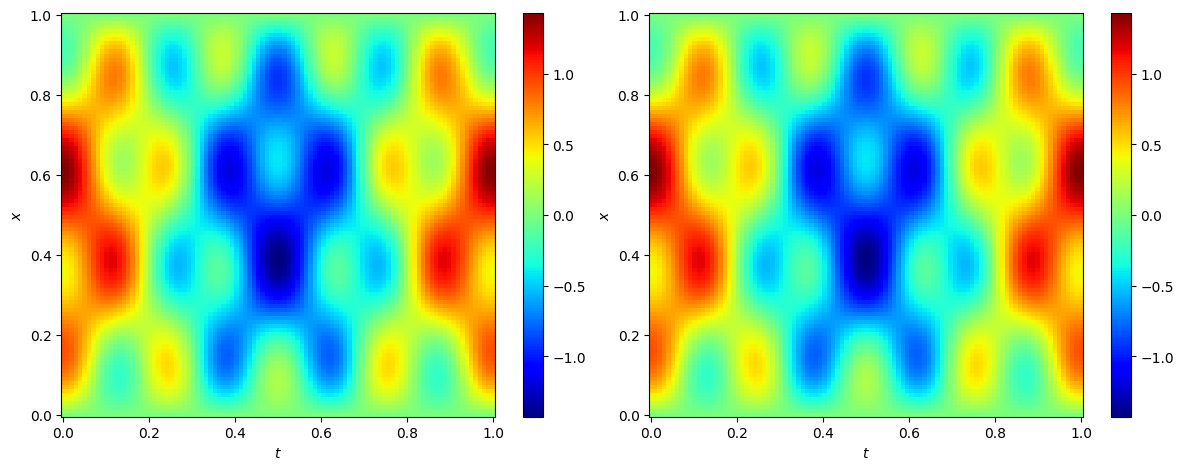

In [ ]:
U_pred = griddata(X_star, torch.real(estimator).cpu().flatten(), (t, x), method='cubic')
U_star = griddata(X_star, u_star.flatten(), (t, x), method='cubic')

color_min = min(min(torch.real(estimator)), min(ground_truth))
color_max = max(max(torch.real(estimator)), max(ground_truth))


plt.figure(figsize=(18, 9))
plt.subplot(2, 3, 1)
plt.pcolor(t, x, U_star, cmap='jet', vmin=color_min, vmax=color_max)
plt.colorbar()
plt.xlabel('$t$')
plt.ylabel('$x$')
#plt.title('Exact u(t, x)')
plt.tight_layout()

plt.subplot(2, 3, 2)
plt.pcolor(t, x, U_pred, cmap='jet', vmin=color_min, vmax=color_max)
plt.colorbar()
plt.xlabel('$t$')
plt.ylabel('$x$')
#plt.title('Predicted u(t, x)')
plt.tight_layout()

plt.savefig('1D_wave_comparison.pdf', bbox_inches='tight')

## Test: different initial condition $\partial_t \neq 1$

In [ ]:
torch.manual_seed(746)
np.random.seed(746)

n = 10**4
epsilon = 10**-2


dom_coords = np.array([[0.4, 0.0],
                        [1.4, 1.0]])

#Initial condition
t = np.array([dom_coords[0,0]])
x = np.linspace(dom_coords[0, 1], dom_coords[1, 1], n)[:, None]
t, x = np.meshgrid(t, x)
t, x = t.flatten(), x.flatten()
X_star = np.hstack((t[:, None], x[:, None]))
i_c = u(X_star, a,c).reshape(-1)

#Initial condition on the derivative
i_c_2 = u(X_star, a,c).reshape(-1) - epsilon*u_t(X_star, a,c ).reshape(-1) + 0.5*c**2*u_xx(X_star, a, c).flatten()*epsilon**2

#Boundary conditions
x2 = np.array([0,1])
t2 = np.linspace(dom_coords[0, 0], dom_coords[1, 0], n)[:, None]
t2, x2 = np.meshgrid(t2, x2)
t2, x2 = t2.flatten(), x2.flatten()
b_c = np.zeros(2*n)


data_t = torch.tensor(np.concatenate((t,t+epsilon,t2))).to(device)
data_x = torch.tensor(np.concatenate((x,x,x2))).to(device)
data_y = torch.tensor(np.concatenate((i_c, i_c_2, b_c))).to(device)

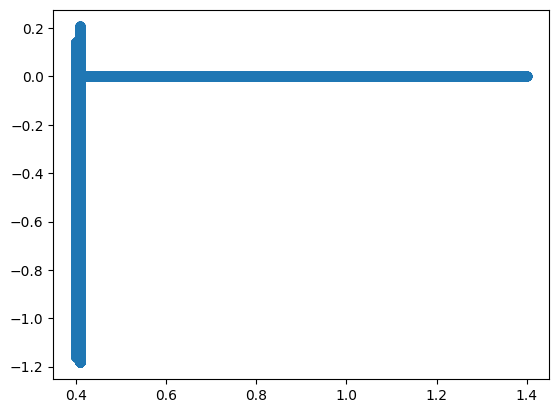

In [ ]:
import matplotlib.pyplot as plt
plt.scatter(data_t.cpu(), data_y.cpu())

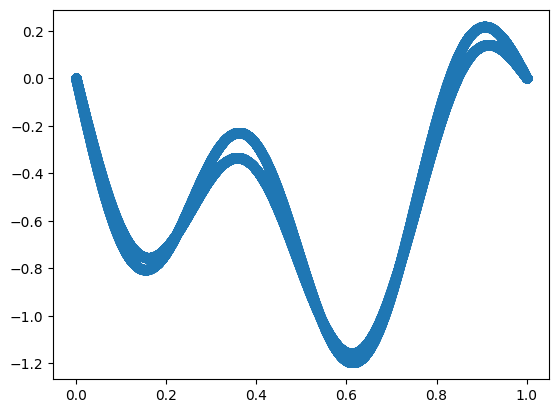

In [ ]:
plt.scatter(data_x.cpu(), data_y.cpu())

In [ ]:
nn = 100 #200
t = np.linspace(dom_coords[0, 0], dom_coords[1, 0], nn)[:, None]
x = np.linspace(dom_coords[0, 1], dom_coords[1, 1], nn)[:, None]
t, x = np.meshgrid(t, x)
t_minus = 2*dom_coords[0, 0] -t
X_star = np.hstack((t_minus.flatten()[:, None], x.flatten()[:, None]))
u_star = u(X_star, a,c).reshape(-1)
X_star = np.hstack((t.flatten()[:, None], x.flatten()[:, None]))


data_zt = torch.tensor(X_star[:,0]).to(device)
data_zx = torch.tensor(X_star[:,1]).to(device)
ground_truth = torch.tensor(u_star).to(device)

In [ ]:
#Recentrage
data_t = data_t-0.9
data_x = data_x-0.5
data_zt = data_zt-0.9
data_zx = data_zx-0.5

In [ ]:
s=2
L=0.5
m=20

domain = "square"

dX = DifferentialOperator({(1, 0): 1})
dY = DifferentialOperator({(0, 1): 1})
PDE = dX**2 - 4*dY**2

n =torch.tensor(n).to(device)
lambda_n, mu_n =  10**-7, 1

regression_vect = RFF_fit(data_t, data_x, data_y, s, m, lambda_n, mu_n, L, domain, PDE, device)
estimator = RFF_estimate(regression_vect, data_zt, data_zx, s, m, n, lambda_n, mu_n, L, domain, PDE, device)

print(torch.mean(torch.square(torch.abs(estimator - ground_truth))))
print(torch.mean(torch.square(torch.abs(ground_truth))))
print(torch.mean(torch.square(torch.abs(estimator))))
error_u = np.sqrt(torch.mean(torch.square(torch.abs(estimator - ground_truth))).item())/np.sqrt(torch.mean(torch.square(ground_truth)).item())
print('Relative L2 error_u: %e' % (error_u))


tensor(8.7252e-07, device='cuda:0')
tensor(0.3103, device='cuda:0')
tensor(0.3099, device='cuda:0')
Relative L2 error_u: 1.676772e-03


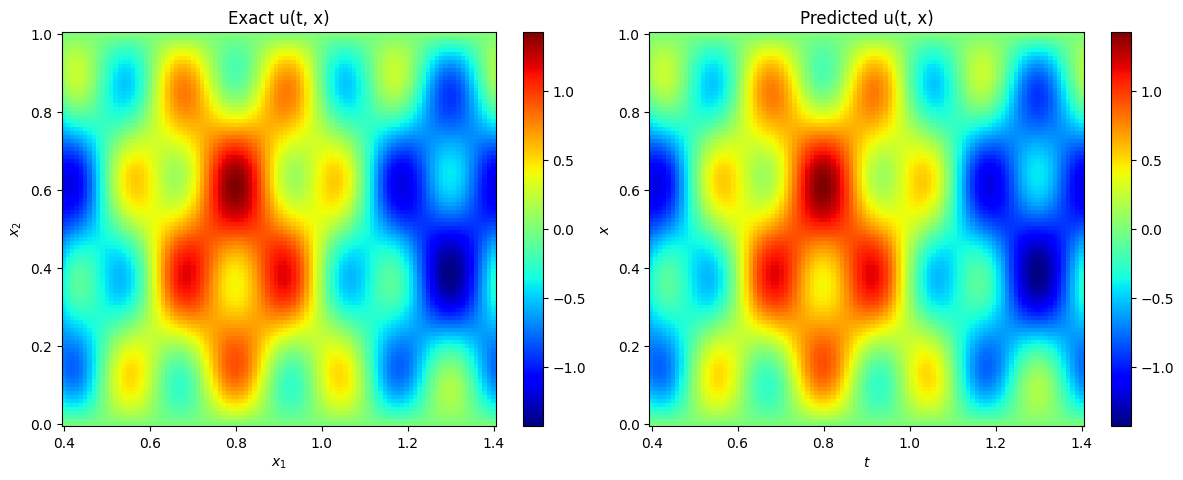

In [ ]:
U_pred = griddata(X_star, torch.real(estimator).cpu().flatten(), (t, x), method='cubic')
U_star = griddata(X_star, u_star.flatten(), (t, x), method='cubic')

color_min = min(min(torch.real(estimator)), min(ground_truth))
color_max = max(max(torch.real(estimator)), max(ground_truth))


plt.figure(figsize=(18, 9))
plt.subplot(2, 3, 1)
plt.pcolor(t, x, U_star, cmap='jet', vmin=color_min, vmax=color_max)
plt.colorbar()
plt.xlabel('$x_1$')
plt.ylabel('$x_2$')
plt.title('Exact u(t, x)')
plt.tight_layout()

plt.subplot(2, 3, 2)
plt.pcolor(t, x, U_pred, cmap='jet', vmin=color_min, vmax=color_max)
plt.colorbar()
plt.xlabel('$t$')
plt.ylabel('$x$')
plt.title('Predicted u(t, x)')
plt.tight_layout()


# Comparison with traditional PDE solvers

## Explicit Euler scheme

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Parameters
L = 1.0           # Length of the domain
T = 1.0           # Total time
Nx = 25*99+1          # Number of spatial points
Nt = 3*(Nx-1)+1        # Number of time steps
dx = L / (Nx - 1) # Spatial step size
dt = T / (Nt-1)  #. T/Nt     # Time step size

# Courant number
c = 2.0
r = c * dt / dx

# Discretize the spatial and time domain
x = np.linspace(0, L, Nx)
t = np.linspace(0, T, Nt)

# Initialize the solution matrix
f = np.zeros((Nt, Nx))

# Initial condition: u(0, x) = sin(pi * x)
f[0, :] = np.sin(np.pi * x) + 0.5 * np.sin(2 * c * np.pi* x)

for n in range(0, Nt-1):
    if n == 0:
        # First time step using the initial velocity condition (du/dt(0, x) = 0)
        f[n+1, :] = f[n, :] +  0.5*r**2 * (np.roll(f[n, :], 1) - 2 * f[n, :] + np.roll(f[n, :], -1))
    else:
        f[n+1, :] = 2 * f[n, :] - f[n-1, :] + r**2 * (np.roll(f[n, :], 1) - 2 * f[n, :] + np.roll(f[n, :], -1))
    # Enforce boundary conditions
    f[n+1, 0] = 0
    f[n+1, Nx-1] = 0

In [ ]:
filter_t = [int(i*((Nt-1)/99)) for i in range(100)]
filter_x = [int(i*((Nx-1)/99)) for i in range(100)]
ix, iy = np.meshgrid(filter_t, filter_x, indexing='ij')

f_plot = np.array(f)[ix, iy]
f_plot = f_plot.flatten()

x = np.linspace(0, L, 100)
t = np.linspace(0, T, 100)

x_plot = np.tile(x, 100).reshape(-1,1)
t_plot = np.array([[j/99 for i in range(100)] for j in range(100)]).reshape(-1,1)
X_star = np.concatenate((t_plot,x_plot), axis=1)
ground_truth = u(X_star, 0.5, c)

t_plot = t_plot.reshape(-1, 100)
x_plot = x_plot.reshape(-1, 100)

l2_err = np.mean(np.square(ground_truth.flatten()-f_plot))
l2_norm = np.mean(np.square(f_plot))
print(l2_err)
print("The L2 relative error is "+ str(np.sqrt(l2_err/l2_norm)))


4.586244204826193e-12
The L2 relative error is 3.831116196234344e-06


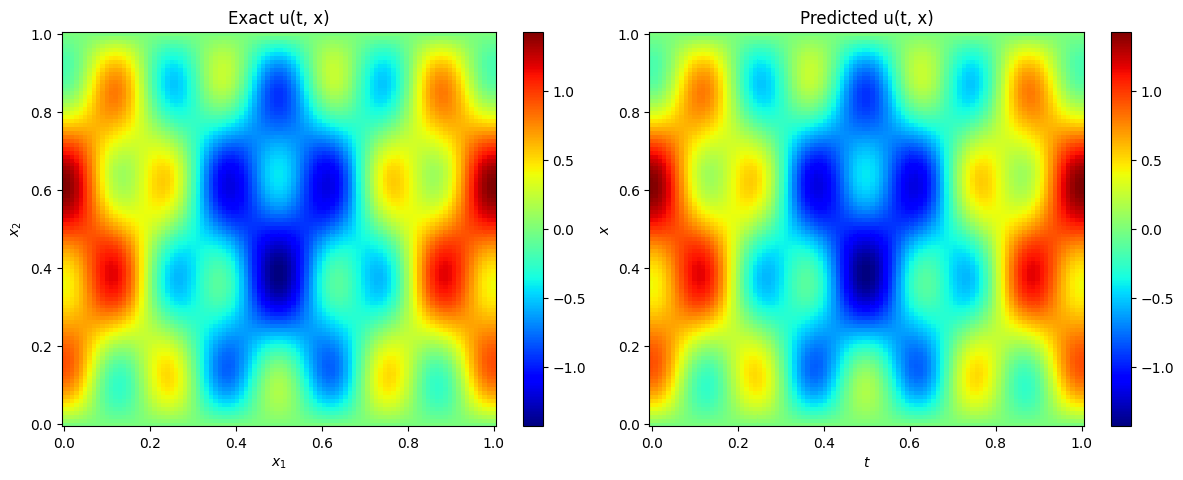

In [ ]:
U_star = griddata(X_star, ground_truth.flatten(), (t_plot, x_plot), method='cubic')
U_pred = griddata(X_star, f_plot, (t_plot, x_plot), method='cubic')

color_min = min(min(f_plot), min(ground_truth))
color_max = max(max(f_plot), max(ground_truth))


plt.figure(figsize=(18, 9))
plt.subplot(2, 3, 1)
plt.pcolor(t_plot, x_plot, U_star, cmap='jet', vmin=color_min, vmax=color_max)
plt.colorbar()
plt.xlabel('$x_1$')
plt.ylabel('$x_2$')
plt.title('Exact u(t, x)')
plt.tight_layout()

plt.subplot(2, 3, 2)
plt.pcolor(t_plot, x_plot, U_pred, cmap='jet', vmin=color_min, vmax=color_max)
plt.colorbar()
plt.xlabel('$t$')
plt.ylabel('$x$')
plt.title('Predicted u(t, x)')
plt.tight_layout()


Alors que théoriquement le schéma d'Euler est d'ordre 2 (erreur = $O(\Delta t^2 + \Delta x^2)$), on observe ici un ordre expérimental de 4 (erreur = $O(\Delta t^4 + \Delta x^4)$).

## Runge Kuta 4

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Parameters
L = 1.0       # Length of the domain
T = 1.0       # Total time
c = 2.0       # Wave speed

Nx = 25*99+1          # Number of spatial points
Nt = 3*(Nx-1)+1        # Number of time steps
dx = L / (Nx - 1) # Spatial step size
dt = T / (Nt-1)  # Time step size

x = np.linspace(0, L, Nx)
t = np.linspace(0, T, Nt)

# Initial conditions
f0 = np.sin(np.pi * x) + 0.5 * np.sin(2 * c * np.pi* x)
df0_dt = np.zeros(Nx)

# Storage for solution
f = np.zeros((Nt, Nx))
f[0, :] = f0

# Second-order spatial derivative
def d2f_dx2(f, dx):
    d2f = np.zeros_like(f)
    d2f[1:-1] = (f[2:] - 2*f[1:-1] + f[:-2]) / dx**2
    return d2f

# RK4 scheme
for n in range(1, Nt):
    k1 = dt * df0_dt
    l1 = dt * c**2 * d2f_dx2(f[n-1, :], dx)

    k2 = dt * (df0_dt + 0.5 * l1)
    l2 = dt * c**2 * d2f_dx2(f[n-1, :] + 0.5 * k1, dx)

    k3 = dt * (df0_dt + 0.5 * l2)
    l3 = dt * c**2 * d2f_dx2(f[n-1, :] + 0.5 * k2, dx)

    k4 = dt * (df0_dt + l3)
    l4 = dt * c**2 * d2f_dx2(f[n-1, :] + k3, dx)

    f[n, :] = f[n-1, :] + (k1 + 2*k2 + 2*k3 + k4) / 6
    df0_dt = df0_dt + (l1 + 2*l2 + 2*l3 + l4) / 6

    # Apply boundary conditions
    f[n, 0] = 0
    f[n, -1] = 0

In [ ]:
filter_t = [int(i*((Nt-1)/99)) for i in range(100)]
filter_x = [int(i*((Nx-1)/99)) for i in range(100)]
ix, iy = np.meshgrid(filter_t, filter_x, indexing='ij')

f_plot = np.array(f)[ix, iy]
f_plot = f_plot.flatten()

x = np.linspace(0, L, 100)
t = np.linspace(0, T, 100)

x_plot = np.tile(x, 100).reshape(-1,1)
t_plot = np.array([[j/99 for i in range(100)] for j in range(100)]).reshape(-1,1)
X_star = np.concatenate((t_plot,x_plot), axis=1)
ground_truth = u(X_star, 0.5, c)

t_plot = t_plot.reshape(-1, 100)
x_plot = x_plot.reshape(-1, 100)

l2_err = np.mean(np.square(ground_truth.flatten()-f_plot))
l2_norm = np.mean(np.square(f_plot))
print(l2_err)
print("The L2 relative error is "+ str(np.sqrt(l2_err/l2_norm)))

1.485943368729159e-11
The L2 relative error is 6.896010121189625e-06


Comme attendu, RK4 est bien d'ordre 4.

## Crank-Nicolson

In [ ]:
# Parameters
sigma = 0.1
type_float = torch.float64

c = 2  # wave speed
L = 1.0  # length of the domain
T = 1.0  # total time
Nx = 25*99+1          # Number of spatial points
Nt = 3*(Nx-1)+1        # Number of time steps

dx = L / (Nx - 1)  # spatial step size
dt = T / (Nt - 1)  # time step size

# Stability condition
s = (c * dt / dx) ** 2
print("s = "+str(s))

# Spatial grid
x = torch.linspace(0, L, Nx, dtype=type_float, device = device)

# Initialize the solution matrix
f = torch.zeros((Nt, Nx), dtype=type_float, device = device)

# Initial conditions
f[0, :] = torch.sin(np.pi * x) + 0.5 * torch.sin(2 * c * np.pi* x)
f[1, :] = f[0, :] +  0.5*s * (torch.roll(f[0, :], 1) - 2 * f[0, :] + torch.roll(f[0, :], -1)) # due to df/dt(0, x) = 0
f[1,0] = 0
f[1,-1] = 0

#Laplacian matrix A and NC matrix A2
A = torch.diagflat(torch.tensor([-1 for i in range(Nx-2)]+ [0], dtype=type_float).to(device), -1) + torch.diagflat(torch.tensor([0]+ [2 for i in range(Nx-2)]+ [0], dtype=type_float).to(device)) + torch.diagflat(torch.tensor([0]+[-1 for i in range(Nx-2)], dtype=type_float).to(device), 1)
A2 = torch.linalg.inv(torch.eye(Nx, dtype=type_float, device=device)+s/2*A)


# Time-stepping using Crank-Nicolson method
for n in range(1, Nt - 1):
    f[n+1, :] = A2@(3*f[n, :] - f[n-1, :]) - f[n, :]
    f[n+1, 0] = 0
    f[n+1, -1] = 0

s = 0.4444444444444444


In [ ]:
filter_t = [int(i*((Nt-1)/99)) for i in range(100)]
filter_x = [int(i*((Nx-1)/99)) for i in range(100)]
ix, iy = np.meshgrid(filter_t, filter_x, indexing='ij')

f_plot = np.array(f.cpu())[ix, iy]
f_plot = f_plot.flatten()

x = np.linspace(0, L, 100)
t = np.linspace(0, T, 100)

x_plot = np.tile(x, 100).reshape(-1,1)
t_plot = np.array([[j/99 for i in range(100)] for j in range(100)]).reshape(-1,1)
X_star = np.concatenate((t_plot,x_plot), axis=1)
ground_truth = u(X_star, 0.5, c)

t_plot = t_plot.reshape(-1, 100)
x_plot = x_plot.reshape(-1, 100)

l2_err = np.mean(np.square(ground_truth.flatten()-f_plot))
l2_norm = np.mean(np.square(f_plot))
print(l2_err)
print(l2_norm)
print("The L2 relative error is "+ str(np.sqrt(l2_err/l2_norm)))

9.65262109007713e-06
0.31082654108877256
The L2 relative error is 0.0055726732783624895


Le schéma est d'ordre 2.

# Noisy boundary conditions

## PIKL

In [ ]:
def training_data(n):
  epsilon = 1/n

  initial_conditions = ics_sampler.sample(n//4)
  boundary_conditions_1 = bc1.sample(n//4)
  boundary_conditions_2 = bc2.sample(n//4)

  data_t = torch.tensor(np.concatenate((initial_conditions[0][:, 0], boundary_conditions_1[0][:, 0], boundary_conditions_2[0][:, 0])))
  data_x = torch.tensor(np.concatenate((initial_conditions[0][:, 1], boundary_conditions_1[0][:, 1], boundary_conditions_2[0][:, 1])))
  data_y = torch.tensor(np.concatenate((initial_conditions[1][:, 0], boundary_conditions_1[1][:, 0], boundary_conditions_2[1][:, 0])))

  increment = 0.5*c**2*u_xx(initial_conditions[0], a, c).flatten()*epsilon**2
  data_t = torch.concatenate((data_t, torch.tensor(initial_conditions[0][:, 0]+epsilon))).to(device)
  data_x = torch.concatenate((data_x, torch.tensor(initial_conditions[0][:, 1]))).to(device)
  data_y = torch.concatenate((data_y, torch.tensor(initial_conditions[1][:, 0]+increment))).to(device)

  return data_t, data_x, data_y

def testing_data(n_test):
  nn = int(np.sqrt(n_test))
  t = np.linspace(dom_coords[0, 0], dom_coords[1, 0], nn)[:, None]
  x = np.linspace(dom_coords[0, 1], dom_coords[1, 1], nn)[:, None]
  t, x = np.meshgrid(t, x)
  X_star = np.hstack((t.flatten()[:, None], x.flatten()[:, None]))
  u_star = u(X_star, a,c).reshape(-1)

  data_zt = torch.tensor(X_star[:,0]).to(device)
  data_zx = torch.tensor(X_star[:,1]).to(device)
  ground_truth = torch.tensor(u_star).to(device)
  return data_zt, data_zx, ground_truth, X_star, t, x, u_star

def centering(shift_t, shift_x, data_t, data_x, data_zt, data_zx):
  data_t = data_t-shift_t
  data_x = data_x-shift_x
  data_zt = data_zt-shift_t
  data_zx = data_zx-shift_x
  return data_t, data_x, data_zt, data_zx

In [ ]:
torch.manual_seed(746)
np.random.seed(746)

n_train = 4*10**4
n_test = 10**4
shift_t, shift_x = 0.5, 0.5

dom_coords = np.array([[0.0, 0.0], [1.0, 1.0]])
s=2
L=0.5
m= 20
domain = "square"

dX = DifferentialOperator({(1, 0): 1})
dY = DifferentialOperator({(0, 1): 1})
PDE = dX**2 - 4*dY**2

lambda_n, mu_n =  10**-6, 10**4

sigma = 0.1

In [ ]:
err = []

for i in range(10):
  data_t, data_x, data_y = training_data(n_train)
  data_y += + sigma*torch.randn(n_train).to(device)
  data_zt, data_zx, ground_truth, X_star, t, x, u_star = testing_data(n_test)
  data_t, data_x, data_zt, data_zx = centering(shift_t, shift_x, data_t, data_x, data_zt, data_zx)
  n =torch.tensor(n_train).to(device)

  regression_vect = RFF_fit(data_t, data_x, data_y, s, m, lambda_n, mu_n, L, domain, PDE, device)
  estimator = RFF_estimate(regression_vect, data_zt, data_zx, s, m, n, lambda_n, mu_n, L, domain, PDE, device)

  error_u = np.sqrt(torch.mean(torch.square(torch.abs(estimator - ground_truth))).item())/np.sqrt(torch.mean(torch.square(ground_truth)).item())
  err.append(error_u)

print('Relative L2 error_u: %e' % (np.mean(err)))
print('STD: %e' % (np.std(err)))


Relative L2 error_u: 1.876177e-02
STD: 6.154248e-03


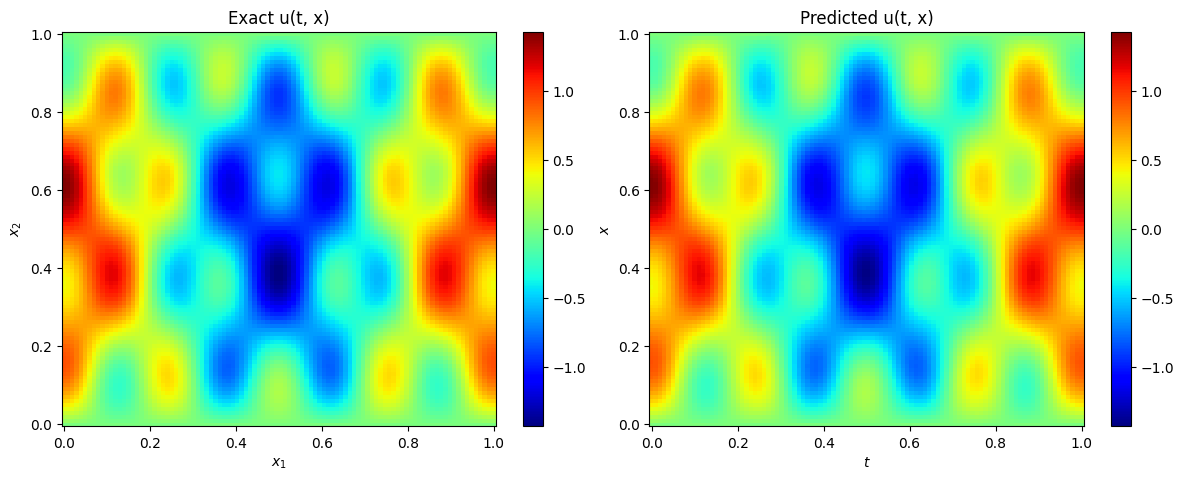

In [ ]:
U_pred = griddata(X_star, torch.real(estimator).cpu().flatten(), (t, x), method='cubic')
U_star = griddata(X_star, u_star.flatten(), (t, x), method='cubic')

color_min = min(min(torch.real(estimator)), min(ground_truth))
color_max = max(max(torch.real(estimator)), max(ground_truth))


plt.figure(figsize=(18, 9))
plt.subplot(2, 3, 1)
plt.pcolor(t, x, U_star, cmap='jet', vmin=color_min, vmax=color_max)
plt.colorbar()
plt.xlabel('$x_1$')
plt.ylabel('$x_2$')
plt.title('Exact u(t, x)')
plt.tight_layout()

plt.subplot(2, 3, 2)
plt.pcolor(t, x, U_pred, cmap='jet', vmin=color_min, vmax=color_max)
plt.colorbar()
plt.xlabel('$t$')
plt.ylabel('$x$')
plt.title('Predicted u(t, x)')
plt.tight_layout()

plt.savefig('1D_wave_comparison.pdf', bbox_inches='tight')

## Euler scheme

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Parameters
sigma = 0.1


L = 1.0           # Length of the domain
T = 1.0           # Total time
Nx = 100*99+1          # Number of spatial points
Nt = 3*(Nx-1)+1        # Number of time steps
dx = L / (Nx - 1) # Spatial step size
dt = T / (Nt-1)  #. T/Nt     # Time step size

# Courant number
c = 2.0
r = c * dt / dx

# Discretize the spatial and time domain
x = np.linspace(0, L, Nx)
t = np.linspace(0, T, Nt)

# Initialize the solution matrix
f = np.zeros((Nt, Nx))

# Initial condition: u(0, x) = sin(pi * x)
f[0, :] = np.sin(np.pi * x) + 0.5 * np.sin(2 * c * np.pi* x) + sigma*np.random.randn(Nx)

for n in range(0, Nt-1):
    if n == 0:
        # First time step using the initial velocity condition (du/dt(0, x) = 0)
        f[n+1, :] = f[n, :] +  0.5*r**2 * (np.roll(f[n, :], 1) - 2 * f[n, :] + np.roll(f[n, :], -1))
    else:
        f[n+1, :] = 2 * f[n, :] - f[n-1, :] + r**2 * (np.roll(f[n, :], 1) - 2 * f[n, :] + np.roll(f[n, :], -1))
    # Enforce boundary conditions
    f[n+1, 0] = 0
    f[n+1, Nx-1] = 0

In [ ]:
filter_t = [int(i*((Nt-1)/99)) for i in range(100)]
filter_x = [int(i*((Nx-1)/99)) for i in range(100)]
ix, iy = np.meshgrid(filter_t, filter_x, indexing='ij')

f_plot = np.array(f)[ix, iy]
f_plot = f_plot.flatten()

x = np.linspace(0, L, 100)
t = np.linspace(0, T, 100)

x_plot = np.tile(x, 100).reshape(-1,1)
t_plot = np.array([[j/99 for i in range(100)] for j in range(100)]).reshape(-1,1)
X_star = np.concatenate((t_plot,x_plot), axis=1)
ground_truth = u(X_star, 0.5, c)

t_plot = t_plot.reshape(-1, 100)
x_plot = x_plot.reshape(-1, 100)

l2_err = np.mean(np.square(ground_truth.flatten()-f_plot))
l2_norm = np.mean(np.square(f_plot))
print(l2_err)
print("The L2 relative error is "+ str(np.sqrt(l2_err/l2_norm)))


0.004996953432627951
The L2 relative error is 0.1251013805699596


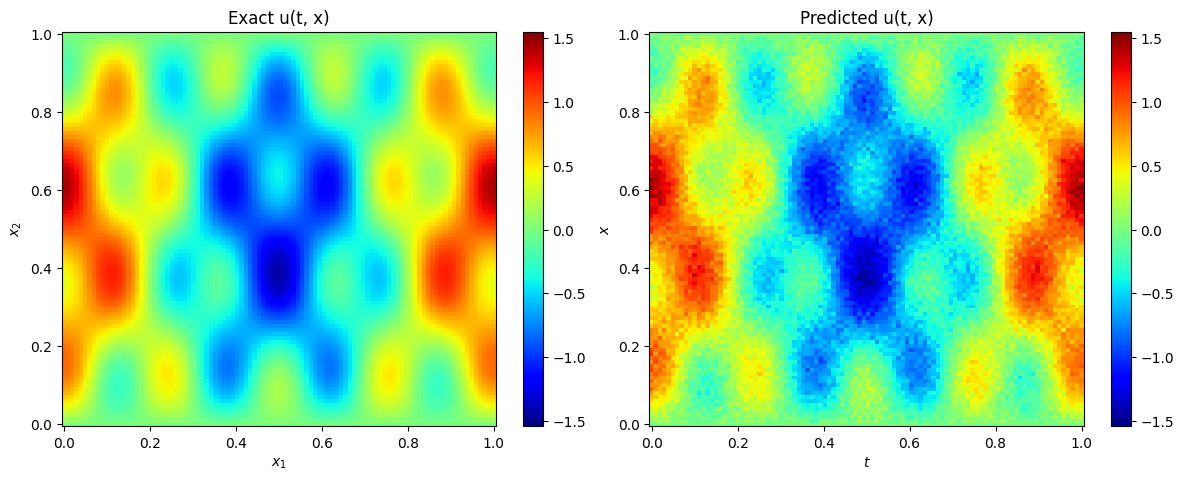

In [ ]:
U_star = griddata(X_star, ground_truth.flatten(), (t_plot, x_plot), method='cubic')
U_pred = griddata(X_star, f_plot, (t_plot, x_plot), method='cubic')

color_min = min(min(f_plot), min(ground_truth))
color_max = max(max(f_plot), max(ground_truth))


plt.figure(figsize=(18, 9))
plt.subplot(2, 3, 1)
plt.pcolor(t_plot, x_plot, U_star, cmap='jet', vmin=color_min, vmax=color_max)
plt.colorbar()
plt.xlabel('$x_1$')
plt.ylabel('$x_2$')
plt.title('Exact u(t, x)')
plt.tight_layout()

plt.subplot(2, 3, 2)
plt.pcolor(t_plot, x_plot, U_pred, cmap='jet', vmin=color_min, vmax=color_max)
plt.colorbar()
plt.xlabel('$t$')
plt.ylabel('$x$')
plt.title('Predicted u(t, x)')
plt.tight_layout()


## RK4

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

np.random.seed(736)

# Parameters
sigma = 0.1
L = 1.0       # Length of the domain
T = 1.0       # Total time
c = 2.0       # Wave speed

Nx = 100*99+1          # Number of spatial points
Nt = 3*(Nx-1)+1        # Number of time steps
dx = L / (Nx - 1) # Spatial step size
dt = T / (Nt-1)  # Time step size

x = np.linspace(0, L, Nx)
t = np.linspace(0, T, Nt)

# Initial conditions
f0 = np.sin(np.pi * x) + 0.5 * np.sin(2 * c * np.pi* x) + sigma*np.random.randn(Nx)
df0_dt = np.zeros(Nx)

# Storage for solution
f = np.zeros((Nt, Nx))
f[0, :] = f0

# Second-order spatial derivative
def d2f_dx2(f, dx):
    d2f = np.zeros_like(f)
    d2f[1:-1] = (f[2:] - 2*f[1:-1] + f[:-2]) / dx**2
    return d2f

# RK4 scheme
for n in range(1, Nt):
    k1 = dt * df0_dt
    l1 = dt * c**2 * d2f_dx2(f[n-1, :], dx)

    k2 = dt * (df0_dt + 0.5 * l1)
    l2 = dt * c**2 * d2f_dx2(f[n-1, :] + 0.5 * k1, dx)

    k3 = dt * (df0_dt + 0.5 * l2)
    l3 = dt * c**2 * d2f_dx2(f[n-1, :] + 0.5 * k2, dx)

    k4 = dt * (df0_dt + l3)
    l4 = dt * c**2 * d2f_dx2(f[n-1, :] + k3, dx)

    f[n, :] = f[n-1, :] + (k1 + 2*k2 + 2*k3 + k4) / 6
    df0_dt = df0_dt + (l1 + 2*l2 + 2*l3 + l4) / 6

    # Apply boundary conditions
    f[n, 0] = 0
    f[n, -1] = 0

In [ ]:
filter_t = [int(i*((Nt-1)/99)) for i in range(100)]
filter_x = [int(i*((Nx-1)/99)) for i in range(100)]
ix, iy = np.meshgrid(filter_t, filter_x, indexing='ij')

f_plot = np.array(f)[ix, iy]
f_plot = f_plot.flatten()

x = np.linspace(0, L, 100)
t = np.linspace(0, T, 100)

x_plot = np.tile(x, 100).reshape(-1,1)
t_plot = np.array([[j/99 for i in range(100)] for j in range(100)]).reshape(-1,1)
X_star = np.concatenate((t_plot,x_plot), axis=1)
ground_truth = u(X_star, 0.5, c)

t_plot = t_plot.reshape(-1, 100)
x_plot = x_plot.reshape(-1, 100)

l2_err = np.mean(np.square(ground_truth.flatten()-f_plot))
l2_norm = np.mean(np.square(f_plot))
print(l2_err)
print("The L2 relative error is "+ str(np.sqrt(l2_err/l2_norm)))

0.0011472907395486892
The L2 relative error is 0.060547158830153484


## Crank-Nicolson

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Parameters
sigma = 0.1
type_float = torch.float64

c = 2  # wave speed
L = 1.0  # length of the domain
T = 1.0  # total time
Nx = 100*99+1          # Number of spatial points
Nt = 3*(Nx-1)+1        # Number of time steps

dx = L / (Nx - 1)  # spatial step size
dt = T / (Nt - 1)  # time step size

# Stability condition
s = (c * dt / dx) ** 2
print("s = "+str(s))

# Spatial grid
x = torch.linspace(0, L, Nx, dtype=type_float, device = device)

# Initialize the solution matrix
f = torch.zeros((Nt, Nx), dtype=type_float, device = device)

# Initial conditions
f[0, :] = torch.sin(np.pi * x) + 0.5 * torch.sin(2 * c * np.pi* x)+ sigma*torch.randn(Nx, dtype= type_float, device=device)
f[1, :] = f[0, :] +  0.5*s * (torch.roll(f[0, :], 1) - 2 * f[0, :] + torch.roll(f[0, :], -1)) # due to df/dt(0, x) = 0
f[1,0] = 0
f[1,-1] = 0

#Laplacian matrix A and NC matrix A2
A = torch.diagflat(torch.tensor([-1 for i in range(Nx-2)]+ [0], dtype=type_float).to(device), -1) + torch.diagflat(torch.tensor([0]+ [2 for i in range(Nx-2)]+ [0], dtype=type_float).to(device)) + torch.diagflat(torch.tensor([0]+[-1 for i in range(Nx-2)], dtype=type_float).to(device), 1)
A2 = torch.linalg.inv(torch.eye(Nx, dtype=type_float, device=device)+s/2*A)


# Time-stepping using Crank-Nicolson method
for n in range(1, Nt - 1):
    f[n+1, :] = A2@(3*f[n, :] - f[n-1, :]) - f[n, :]
    f[n+1, 0] = 0
    f[n+1, -1] = 0

s = 0.4444444444444444


In [ ]:
filter_t = [int(i*((Nt-1)/99)) for i in range(100)]
filter_x = [int(i*((Nx-1)/99)) for i in range(100)]
ix, iy = np.meshgrid(filter_t, filter_x, indexing='ij')

f_plot = np.array(f.cpu())[ix, iy]
f_plot = f_plot.flatten()

x = np.linspace(0, L, 100)
t = np.linspace(0, T, 100)

x_plot = np.tile(x, 100).reshape(-1,1)
t_plot = np.array([[j/99 for i in range(100)] for j in range(100)]).reshape(-1,1)
X_star = np.concatenate((t_plot,x_plot), axis=1)
ground_truth = u(X_star, 0.5, c)

t_plot = t_plot.reshape(-1, 100)
x_plot = x_plot.reshape(-1, 100)

l2_err = np.mean(np.square(ground_truth.flatten()-f_plot))
l2_norm = np.mean(np.square(f_plot))
print(l2_err)
print(l2_norm)
print("The L2 relative error is "+ str(np.sqrt(l2_err/l2_norm)))

0.00012638445027458894
0.3128078913908731
The L2 relative error is 0.020100551415216335


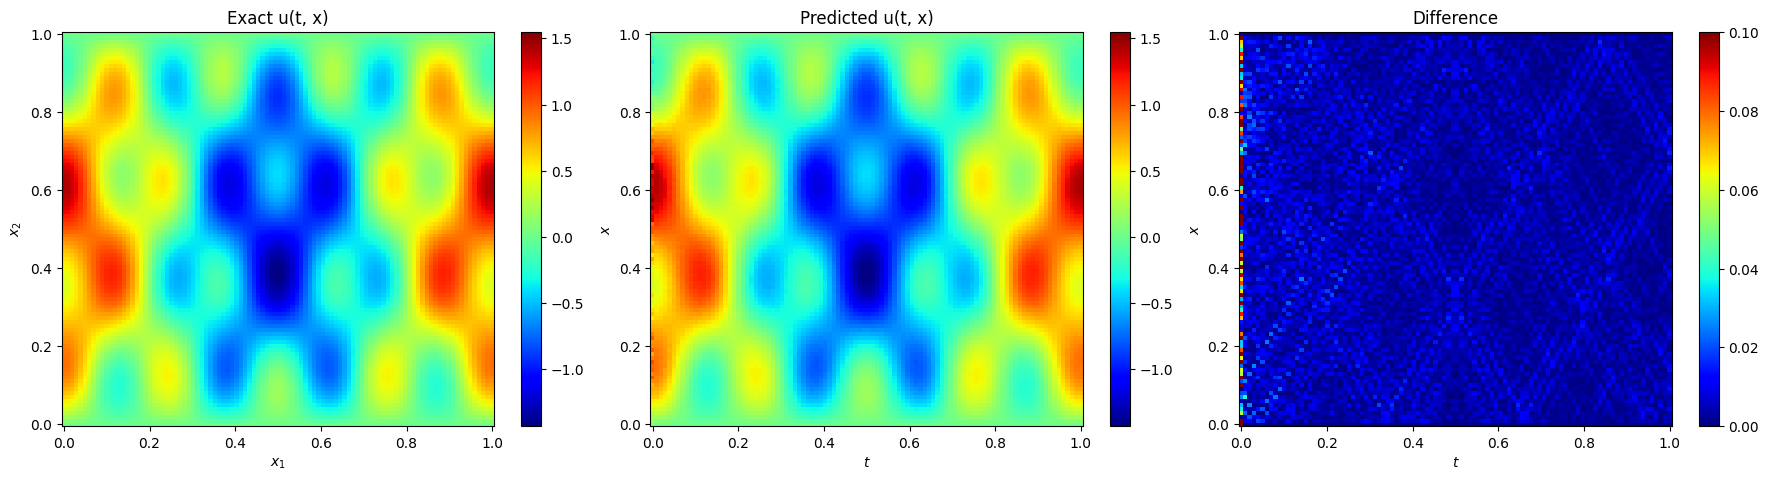

In [ ]:
U_star = griddata(X_star, ground_truth.flatten(), (t_plot, x_plot), method='cubic')
U_pred = griddata(X_star, f_plot, (t_plot, x_plot), method='cubic')

diff= np.abs(f_plot-ground_truth.flatten())
Diff = griddata(X_star, diff, (t_plot, x_plot), method='cubic')

color_min = min(min(f_plot), min(ground_truth))
color_max = max(max(f_plot), max(ground_truth))


plt.figure(figsize=(18, 9))
plt.subplot(2, 3, 1)
plt.pcolor(t_plot, x_plot, U_star, cmap='jet', vmin=color_min, vmax=color_max)
plt.colorbar()
plt.xlabel('$x_1$')
plt.ylabel('$x_2$')
plt.title('Exact u(t, x)')
plt.tight_layout()

plt.subplot(2, 3, 2)
plt.pcolor(t_plot, x_plot, U_pred, cmap='jet', vmin=color_min, vmax=color_max)
plt.colorbar()
plt.xlabel('$t$')
plt.ylabel('$x$')
plt.title('Predicted u(t, x)')
plt.tight_layout()


color_min_diff = min(diff)
color_max_diff = 0.1
plt.subplot(2, 3, 3)
plt.pcolor(t_plot, x_plot, Diff, cmap='jet', vmin=color_min_diff, vmax=color_max_diff)
plt.colorbar()
plt.xlabel('$t$')
plt.ylabel('$x$')
plt.title('Difference')
plt.tight_layout()


## PINNs

In [39]:
class Sampler_noisy:
    # Initialize the class
    def __init__(self, dim, coords, func, name = None, std = 0.1):
        self.dim = dim
        self.coords = coords
        self.func = func
        self.name = name
    def sample(self, N):
        x = self.coords[0:1,:] + (self.coords[1:2,:]-self.coords[0:1,:])*np.random.rand(N, self.dim)
        y = self.func(x) + np.random.randn(N,1)
        return x, y

In [40]:
# Domain boundaries
ics_coords = np.array([[0.0, 0.0],
                        [0.0, 1.0]])
bc1_coords = np.array([[0.0, 0.0],
                        [1.0, 0.0]])
bc2_coords = np.array([[0.0, 1.0],
                        [1.0, 1.0]])
dom_coords = np.array([[0.0, 0.0],
                        [1.0, 1.0]])

# Create initial conditions samplers
ics_sampler_noisy = Sampler_noisy(2, ics_coords, lambda x: u(x, a, c), name='Initial Condition 1')

# Create boundary conditions samplers
bc1_noisy = Sampler_noisy(2, bc1_coords, lambda x: u(x, a, c), name='Dirichlet BC1')
bc2_noisy = Sampler_noisy(2, bc2_coords, lambda x: u(x, a, c), name='Dirichlet BC2')
bcs_sampler_noisy = [bc1_noisy, bc2_noisy]

In [47]:
# Define PINN model
np.random.seed(746)

layers = [2, 500, 500, 500, 1]
kernel_size = 300
model = PINN(layers, operator, ics_sampler_noisy, bcs_sampler_noisy, res_sampler, c, kernel_size)

# Train model
iterations = 80001
model.train(nIter=iterations, batch_size=kernel_size)

Device mapping:
/job:localhost/replica:0/task:0/device:GPU:0 -> device: 0, name: NVIDIA L4, pci bus id: 0000:00:03.0, compute capability: 8.9

It: 0, Loss: 2.424e+01, Loss_res: 1.271e+01,  Loss_bcs: 8.976e+00, Loss_ut_ics: 2.554e+00,, Time: 1.18
lambda_u: 1.000e+00
lambda_ut: 1.000e+00
lambda_r: 1.000e+00
It: 100, Loss: 1.155e+00, Loss_res: 1.154e-02,  Loss_bcs: 1.123e+00, Loss_ut_ics: 2.026e-02,, Time: 0.55
lambda_u: 1.000e+00
lambda_ut: 1.000e+00
lambda_r: 1.000e+00
It: 200, Loss: 1.445e+00, Loss_res: 2.718e-03,  Loss_bcs: 1.440e+00, Loss_ut_ics: 2.000e-03,, Time: 0.55
lambda_u: 1.000e+00
lambda_ut: 1.000e+00
lambda_r: 1.000e+00
It: 300, Loss: 1.681e+00, Loss_res: 1.200e-02,  Loss_bcs: 1.626e+00, Loss_ut_ics: 4.326e-02,, Time: 0.54
lambda_u: 1.000e+00
lambda_ut: 1.000e+00
lambda_r: 1.000e+00
It: 400, Loss: 1.317e+00, Loss_res: 2.970e-03,  Loss_bcs: 1.306e+00, Loss_ut_ics: 7.542e-03,, Time: 0.55
lambda_u: 1.000e+00
lambda_ut: 1.000e+00
lambda_r: 1.000e+00
It: 500, Loss: 1.369e+00, Los

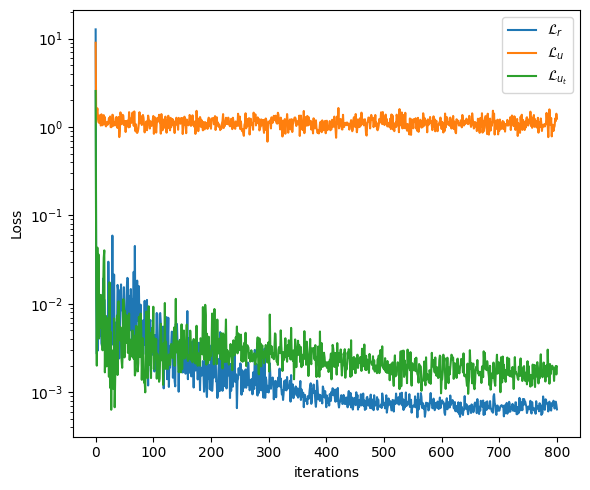

In [48]:
loss_res = model.loss_res_log
loss_bcs = model.loss_bcs_log
loss_u_t_ics = model.loss_ut_ics_log

fig = plt.figure(figsize=(6, 5))
plt.plot(loss_res, label='$\mathcal{L}_{r}$')
plt.plot(loss_bcs, label='$\mathcal{L}_{u}$')
plt.plot(loss_u_t_ics, label='$\mathcal{L}_{u_t}$')
plt.yscale('log')
plt.xlabel('iterations')
plt.ylabel('Loss')
plt.legend()
plt.tight_layout()
plt.savefig('nn_training_loss.pdf', bbox_inches='tight')
plt.show()

In [49]:
nn = 100
t = np.linspace(dom_coords[0, 0], dom_coords[1, 0], nn)[:, None]
x = np.linspace(dom_coords[0, 1], dom_coords[1, 1], nn)[:, None]
t, x = np.meshgrid(t, x)
X_star = np.hstack((t.flatten()[:, None], x.flatten()[:, None]))

u_star = u(X_star, a,c)
R_star = r(X_star, a, c)

# Predictions
u_pred = model.predict_u(X_star)
r_pred = model.predict_r(X_star)
error_u = np.linalg.norm(u_star - u_pred, 2) / np.linalg.norm(u_star, 2)

print('Relative L2 error_u: %e' % (error_u))

Relative L2 error_u: 4.740444e-01


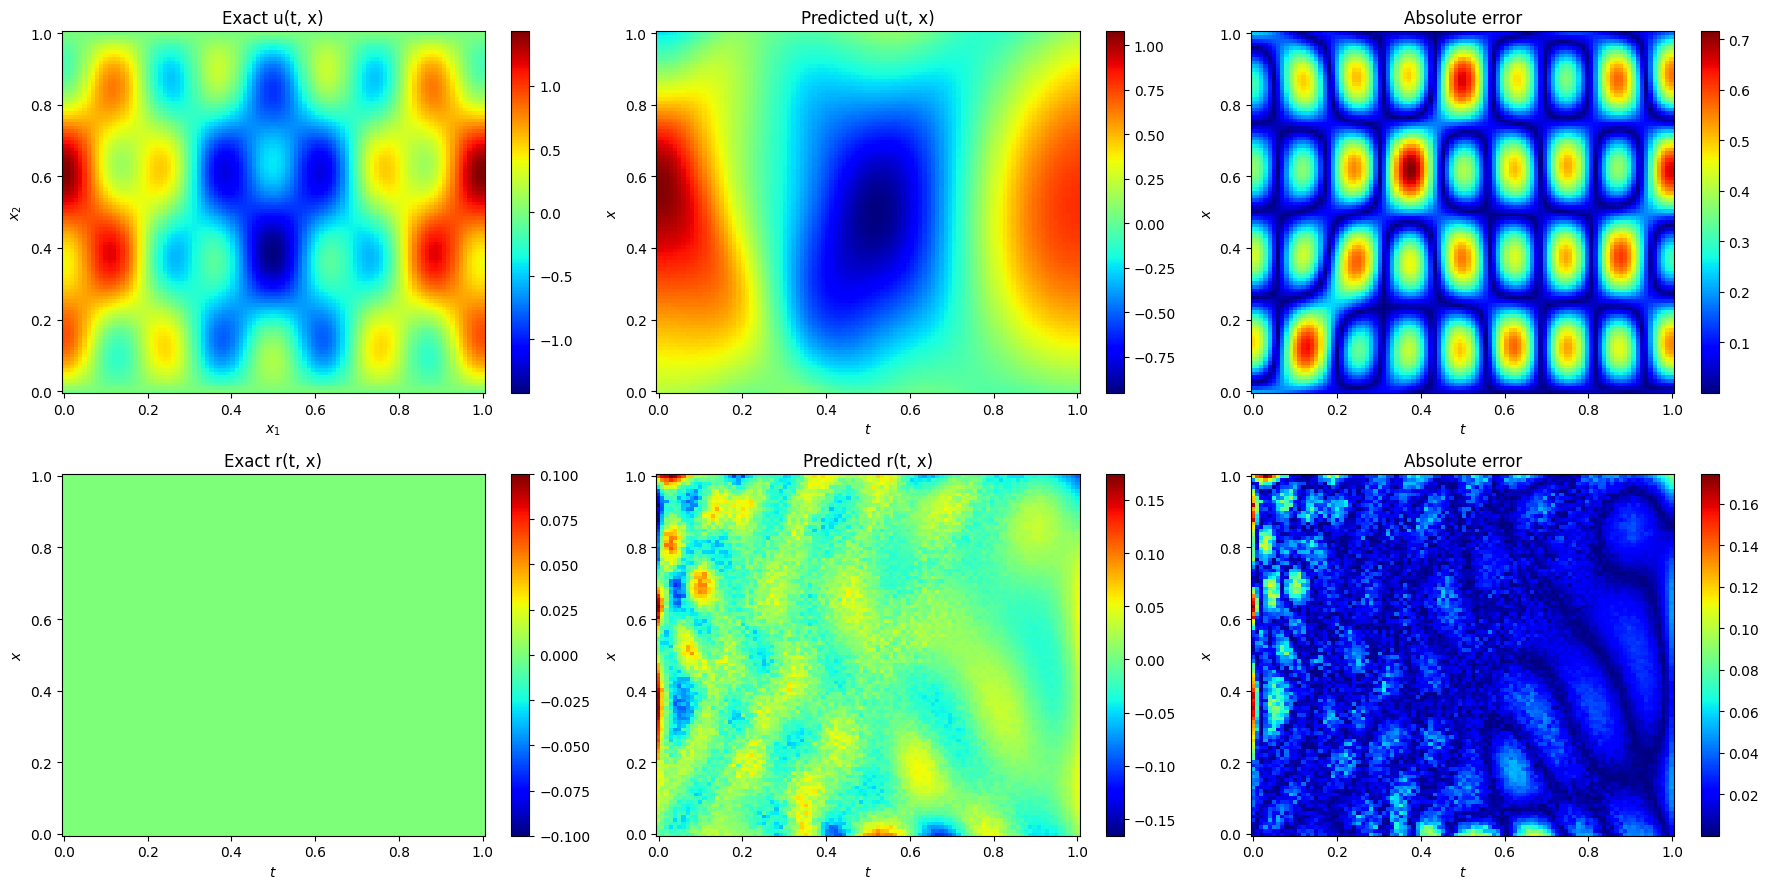

In [51]:
U_star = griddata(X_star, u_star.flatten(), (t, x), method='cubic')
R_star = griddata(X_star, R_star.flatten(), (t, x), method='cubic')
U_pred = griddata(X_star, u_pred.flatten(), (t, x), method='cubic')
R_pred = griddata(X_star, r_pred.flatten(), (t, x), method='cubic')


plt.figure(figsize=(18, 9))
plt.subplot(2, 3, 1)
plt.pcolor(t, x, U_star, cmap='jet')
plt.colorbar()
plt.xlabel('$x_1$')
plt.ylabel('$x_2$')
plt.title('Exact u(t, x)')
plt.tight_layout()

plt.subplot(2, 3, 2)
plt.pcolor(t, x, U_pred, cmap='jet')
plt.colorbar()
plt.xlabel('$t$')
plt.ylabel('$x$')
plt.title('Predicted u(t, x)')
plt.tight_layout()

plt.subplot(2, 3, 3)
plt.pcolor(t, x, np.abs(U_star - U_pred), cmap='jet')
plt.colorbar()
plt.xlabel('$t$')
plt.ylabel('$x$')
plt.title('Absolute error')
plt.tight_layout()

plt.subplot(2, 3, 4)
plt.pcolor(t, x, R_star, cmap='jet')
plt.colorbar()
plt.xlabel('$t$')
plt.ylabel('$x$')
plt.title('Exact r(t, x)')
plt.tight_layout()

plt.subplot(2, 3, 5)
plt.pcolor(t, x, R_pred, cmap='jet')
plt.colorbar()
plt.xlabel('$t$')
plt.ylabel('$x$')
plt.title('Predicted r(t, x)')
plt.tight_layout()

plt.subplot(2, 3, 6)
plt.pcolor(t, x, np.abs(R_star - R_pred), cmap='jet')
plt.colorbar()
plt.xlabel('$t$')
plt.ylabel('$x$')
plt.title('Absolute error')
plt.tight_layout()
plt.savefig('1D_wave_nn_noise.pdf', bbox_inches='tight')
plt.show()
